# Maximum Likelihood Estimation State Tomography Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [1]:
!pip install qsttoolkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 22.6 MB/s eta 0:00:00


## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import qsttoolkit as qst

## Data Preparation

We start by defining the dimensionality of our system as `Nc`, and the phase space grids for our Husimi-Q function measurement data. These grids are also defined to be `Nc` x `Nc` for simplicity:

In [3]:
Nc = 32
xgrid = np.linspace(-5, 5, Nc)
pgrid = np.linspace(-5, 5, Nc)

We first create test state density matrices of seven different varieties using the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework. The first three states can be produced directly using QuTiP functions, the other four are specific superpositions of Fock and coherent states and are produced using custom functions in `qsttoolkit.data`:

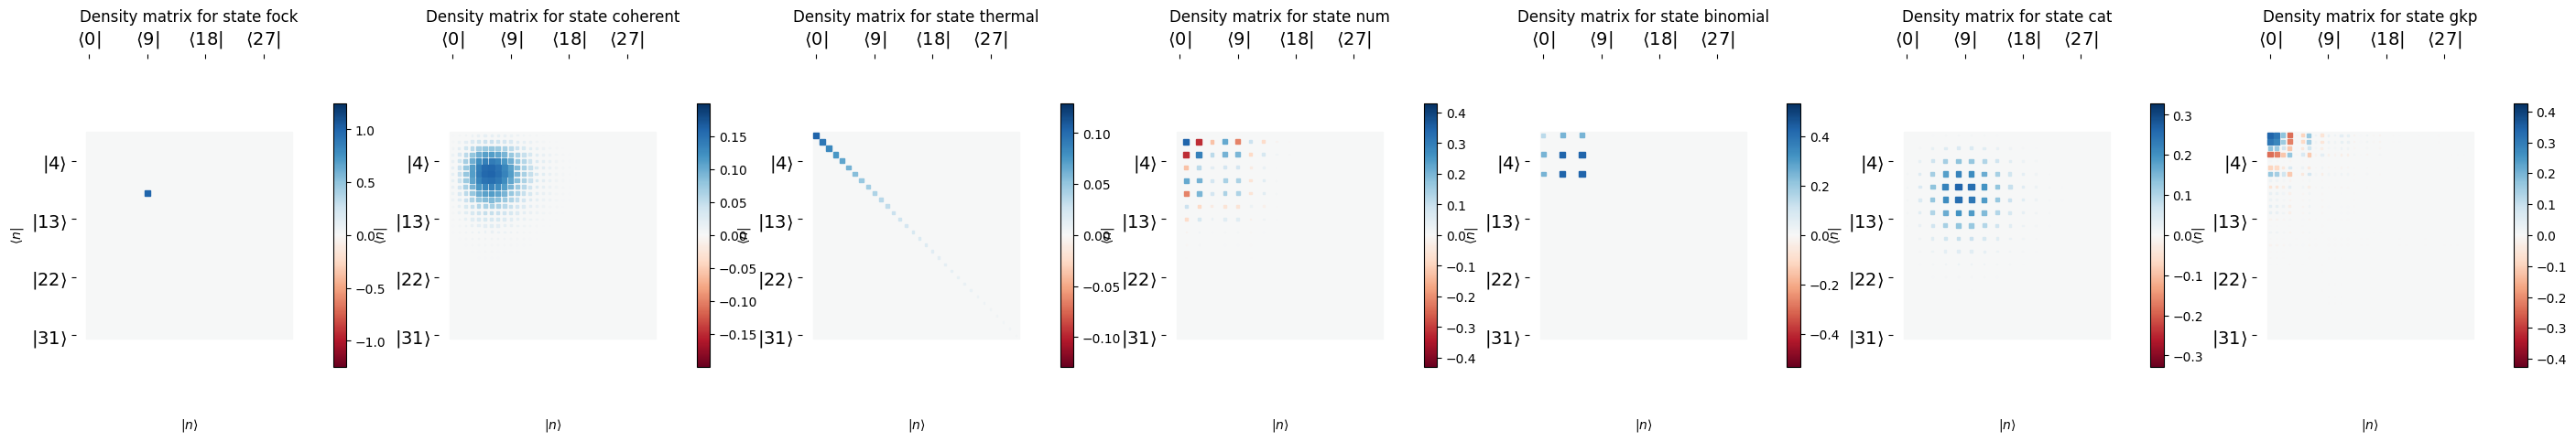

In [4]:
fock_test = qt.fock_dm(Nc, 9)
coherent_test = qt.coherent_dm(Nc, 2.5)
thermal_test = qt.thermal_dm(Nc, 9)
num_test = qt.ket2dm(qst.data.num_state('M2', Nc))
binomial_test = qt.ket2dm(qst.data.binomial_state(Nc, 2, 2, 1))
cat_test = qt.ket2dm(qst.data.cat_state(Nc, 3))
gkp_test = qt.ket2dm(qst.data.gkp_state(Nc, [-5, 5], [-5, 5], 0.5, 4.5))

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
qst.plot_hinton(fock_test, ax=ax[0], label='fock')
qst.plot_hinton(coherent_test, ax=ax[1], label='coherent')
qst.plot_hinton(thermal_test, ax=ax[2], label='thermal')
qst.plot_hinton(num_test, ax=ax[3], label='num')
qst.plot_hinton(binomial_test, ax=ax[4], label='binomial')
qst.plot_hinton(cat_test, ax=ax[5], label='cat')
qst.plot_hinton(gkp_test, ax=ax[6], label='gkp')
plt.show()

We create the measurement operators for
- Photon occupation number measurement
- Homodyne detection phase space Husimi-Q measurement
using functions from `qsttoolkit.tomography`:

In [5]:
photon_number_measurement_operators = qst.tomography.measurement_operators(Nc, 'photon_number')
Husimi_Q_measurement_operators = qst.tomography.measurement_operators(Nc, 'Husimi-Q', xgrid=xgrid, pgrid=pgrid)

We then create the measurement data for our test state, applying mixed state noise using `qsttoolkit.data.mixed_state_noise()`:

In [6]:
test_state = qst.data.mixed_state_noise(thermal_test, 0.4)
photon_number_measurement_data = np.diag(test_state.full())       # Photon occupation number probabilities
Husimi_Q_measurement_data = qt.qfunc(test_state, xgrid, pgrid)    # Husimi-Q phase space measurement probabilities

Redefine `test_state` and `measurement_operators` below with the different states and operators created above:

In [7]:
measurement_data = photon_number_measurement_data.flatten()
measurement_operators = photon_number_measurement_operators

## Modelling

We create an instance of the `qsttoolkit.tomography.MLEQuantumStateTomography` class, which handles the setup, performing and evaluation of the optimisation:

In [8]:
MLE_reconstructor = qst.tomography.MLEQuantumStateTomography(Nc)

Optimisation of the density matrix parameterisation using the `.reconstruct` method:

In [9]:
MLE_reconstructor.reconstruct(measurement_data = measurement_data,
                              measurement_operators = measurement_operators,
                              initial_dm = qst.maximally_mixed_state_dm(Nc).full(),
                              method = 'CG',
                              verbose = True)

/usr/local/lib/python3.11/dist-packages/qsttoolkit/tomography/tradqst/MLE.py:109: RuntimeWarning: Method CG cannot handle constraints.
  self.result = minimize(log_likelihood,
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:612: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/usr/local/lib/python3.11/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)
/usr/local/lib/python3.11/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:612: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


Current cost: (3.325481236070555-9.973047063175481e-20j)


/usr/local/lib/python3.11/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:235: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:612: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


Current cost: (3.3240733136465845-8.75889685163039e-20j)
Current cost: (3.32262256218749-7.849475896939734e-20j)
Current cost: (3.322621852513705-7.821959647554861e-20j)
Optimization terminated successfully.
         Current function value: 3.322622
         Iterations: 4
         Function evaluations: 9233
         Gradient evaluations: 9
Optimisation terminated successfully: True


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_optimize.py:1814: ComplexWarning: Casting complex values to real discards the imaginary part
  print("         Current function value: %f" % fval)


## Analysis

Model statistics over optimisation progress:

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


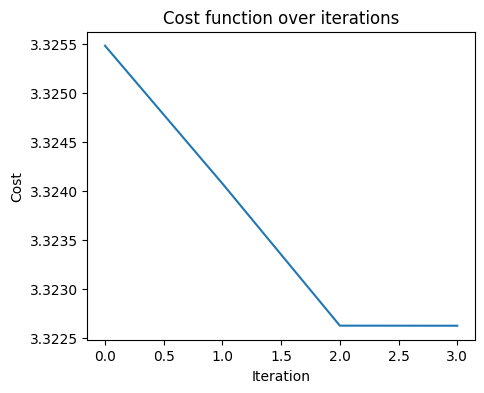

In [10]:
MLE_reconstructor.plot_cost_values()

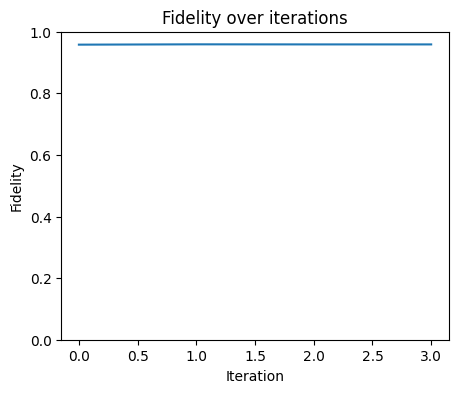

In [11]:
MLE_reconstructor.plot_fidelities(test_state)

Comparison of the true and reconstructed states

In [12]:
print(f"State fidelity: {qst.fidelity(test_state.full(), MLE_reconstructor.reconstructed_dm)}")

State fidelity: 0.958787759470482


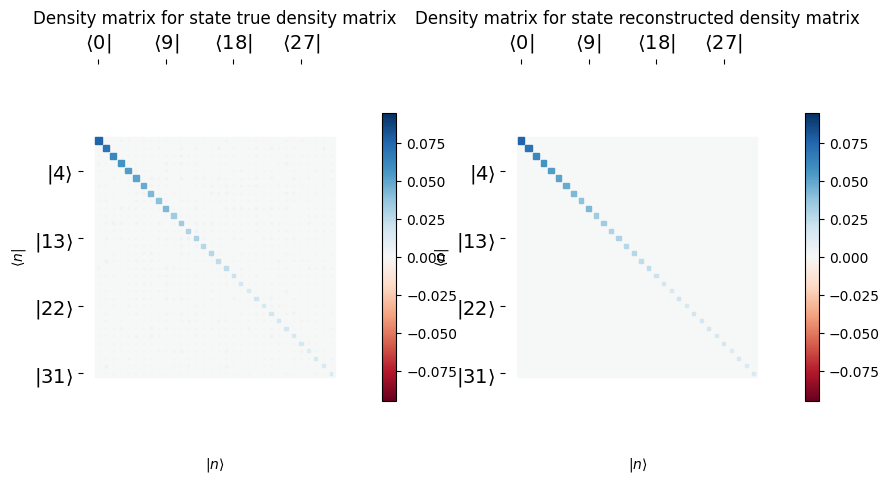

In [13]:
MLE_reconstructor.plot_comparison_hintons(test_state)

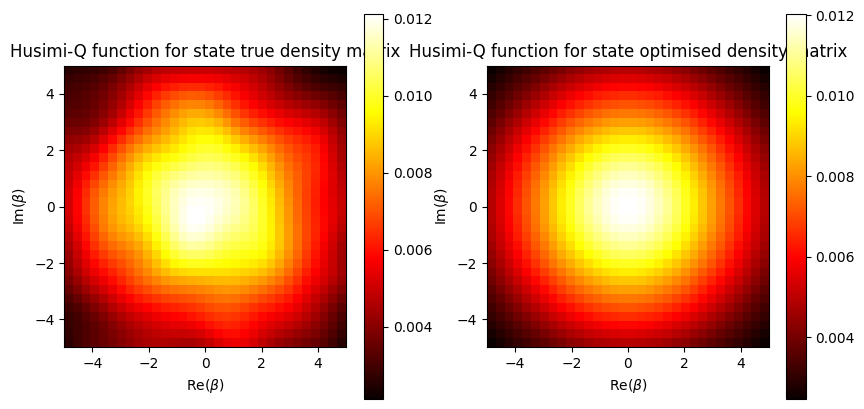

In [14]:
MLE_reconstructor.plot_comparison_Husimi_Qs(test_state, xgrid, pgrid)

Inspection of reconstructions from intermediate parameterisations during optimisation:

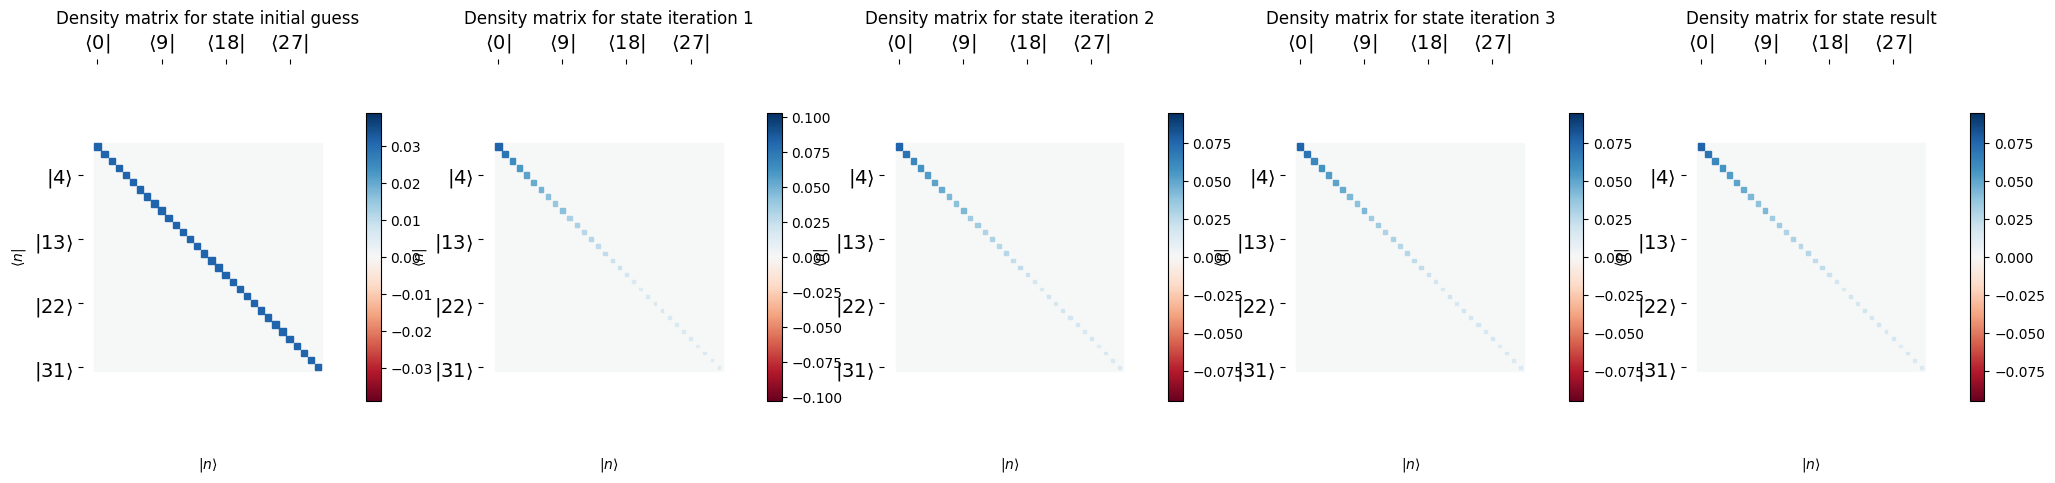

In [15]:
MLE_reconstructor.plot_intermediate_hintons()

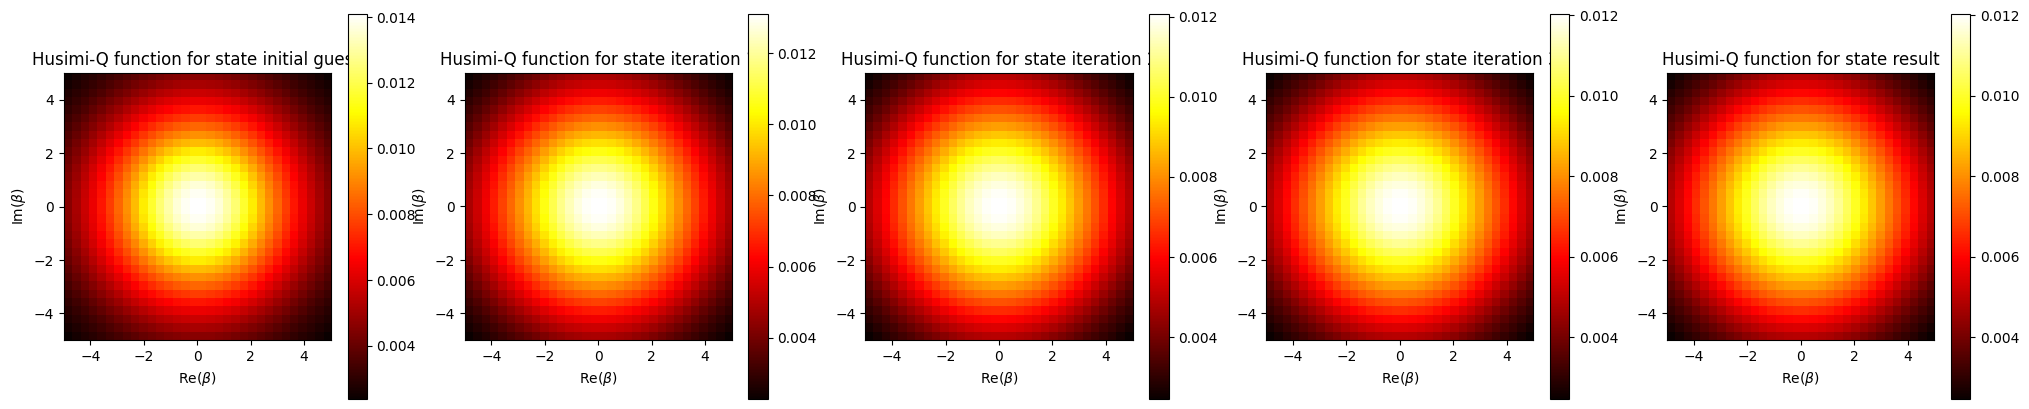

In [16]:
MLE_reconstructor.plot_intermediate_Husimi_Qs(xgrid, pgrid)